<a href="https://colab.research.google.com/github/Abdelmounim1996/Distributed-Learning-of-Finite-Gaussian-Mixtures/blob/main/GMR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyspark

     |████████████████████████████████| 281.3 MB 39 kB/s 
     |████████████████████████████████| 198 kB 60.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=b745fadf49222586692321fb68a6328175b31992fa71d600510ee5f7700f9c76
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [2]:
import numpy as np
from scipy.stats import multivariate_normal
import time

In [3]:
"""machaine learning  library"""
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture 

In [4]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [5]:
from sklearn.datasets import make_blobs

In [6]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.rdd import RDD
from pyspark.mllib.linalg import  DenseVector , DenseMatrix , _convert_to_vector
from pyspark.mllib.common import callMLlibFunc
import array as pyarray

In [7]:
spark = SparkSession.builder.master("local[*]") \
                    .appName('Distributed Learning of Finite Gaussian Mixtures') \
                    .getOrCreate()
sc = spark.sparkContext


In [8]:
n_samples_ = 10000
k = 10
X, y_true = make_blobs(n_samples=n_samples_,
                       n_features = 2 , centers=k,
                       cluster_std=0.5,
                       random_state=0)

In [9]:
data_make = sc.parallelize(X , 4 )

In [10]:
class EM_pMLE:
    def __init__(self ,  n_components  ):
        self.n_components = n_components

    def fit(self , X  : int , n_iters = 500 , tol = 0.01 , init_params = None ):
        self.X            = X
        self.n_iters      = n_iters
        self.tol          = tol
        self.init_params  = init_params
        self.N , self.d   = self.X.shape
        self.converged    = False
        self.S_x          = np.cov(self.X , rowvar=False)
        self.Means   = None 
        self.Covars  = None 
        self.Weights = None
        np.seterr(divide='ignore', invalid='ignore')
        
        # initializations 
        if  self.init_params is  None:
          start = time.time()
          self.Means        = KMeans( n_clusters = self.n_components, random_state=0).fit(self.X).cluster_centers_
          self.Covars       = np.full((self.n_components , self.d , self.d),np.identity(self.d) ) 
          self.Weights      = np.full( shape=self.n_components , fill_value=1./self.n_components)
          end = time.time()
          print("kmeans sklearn time : ", end - start)
        else :
          self.Means   = self.init_params[0]
          self.Covars  = self.init_params[1]
          self.Weights = self.init_params[2]
        
        # start algorithm : 
        dis_likelihood = [[np.infty , np.infty] ]
        for it in range(self.n_iters):
            self.likelihood ( self.X  )
            dis_likelihood.append(self.penalized_likelihood())
            if abs(dis_likelihood[it+1][1]-dis_likelihood[it][1]) <= self.tol : 
                self.converged = True
                self.max_iters = it 
                break
            self.E_step() 
            self.M_step()
        self.max_likelihood = dis_likelihood[1:]
        # end algorithm
        return self

    def likelihood (self , data  ):
        self.likelihood_weighted = np.asarray(
        [  multivariate_normal(mu , sigma , allow_singular = True).pdf( data) for mu , sigma in zip(self.Means ,
                                                                   self.Covars) ])* self.Weights[: , np.newaxis]

    def penalized_likelihood(self):
        an =1./np.sqrt(self.N) 
        log_likelihood_EM_pLME  = (np.log( self.likelihood_weighted)[(self.likelihood_weighted ==self.likelihood_weighted.max(0))]).sum()
        log_likelihood_EM       = np.log(     self.likelihood_weighted.sum(0)       ).sum() 
        penalty_quantity        = (an*( np.trace(self.S_x*np.linalg.pinv(self.Covars), axis1 = 1 , axis2 = 2) \
                                       + np.log(np.linalg.det(self.Covars)) ) ).sum()
        return log_likelihood_EM_pLME - penalty_quantity , log_likelihood_EM-penalty_quantity

    def E_step(self) :
        self.conditional_expectation =  self.likelihood_weighted  / self.likelihood_weighted .sum(0) 
        self.likelihood_weighted = None 

    def M_step(self):
        an = 1/np.sqrt(self.N) 
        self.Weights =  (1./self.N)*self.conditional_expectation.sum(1)
        self.Means = np.dot(self.conditional_expectation , self.X)*(  1/(self.N*self.Weights))[:,np.newaxis]
        
        Mu = self.X -self.Means[:, np.newaxis]
        S = np.add.reduce((self.conditional_expectation)[:,:, np.newaxis , np.newaxis] * \
                        (np.repeat( Mu, self.d , axis = 1 ).reshape(-1,  self.d )*\
                         Mu.ravel()[: , np.newaxis] ).reshape(self.n_components ,-1 ,self.d  , self.d )
                         , axis = 1 )
        self.conditional_expectation = None 
        self.Covars = (1./(2*an + self.N*self.Weights))[:,np.newaxis , np.newaxis]*(2*an*self.S_x + S)
  
    def predict(self , data ):   
        self.likelihood( data )
        return self.likelihood_weighted .argmax(0)
    

In [11]:
%%time
model = EM_pMLE(k).fit(X)

kmeans sklearn time :  0.19033265113830566
CPU times: user 358 ms, sys: 262 ms, total: 619 ms
Wall time: 381 ms


In [12]:
%%time
"""predictions data testing  """
labels = model.predict(X)

CPU times: user 11.8 ms, sys: 175 µs, total: 12 ms
Wall time: 12.6 ms


In [13]:
"""test convergence """
model.converged , model.max_iters

(True, 5)

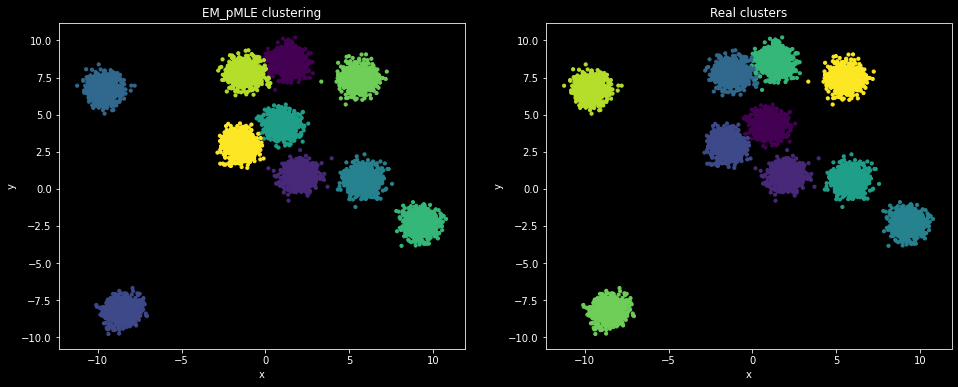

In [14]:
"""Plotting data """
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(X[:,0], X[:,1], s = 10  ,c = labels , cmap='viridis')
ax2.scatter(X[:,0], X[:,1], s = 10 , c = y_true, cmap='viridis')
ax1.set_title('EM_pMLE clustering')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax2.set_title('Real clusters')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
plt.show()

In [15]:

def Kullback_Leibler_Distance(G1 , G2 ):
  Means_1 , Covars_1 = G1
  Means_2 , Covars_2 = G2
  Sigma_inv = np.linalg.pinv(Covars_2)
  k,d = Means_2.shape ; m, d = Means_1.shape ;  KL_dis_gmm = np.empty((m, k))
  xdiff = Means_1-Means_2[0]
  for i in range(k):
    xdiff = Means_1-Means_2[i]
    KL_dis_gmm[:, i] = 0.5*(  np.log(np.abs( np.linalg.det(Covars_2[i])/ np.linalg.det(Covars_1)) )\
                            + np.trace(np.dot( Covars_1 , Sigma_inv[i]  ) , axis1 = 1 , axis2 = 2 )  
  +  (xdiff.dot( Sigma_inv[i])*xdiff).sum(axis=-1) -d ) 
  return np.abs(KL_dis_gmm)

In [16]:
class  Gaussian_mixture_reduction :
    
    def __init__(self , n_components : int   ):
        self.n_components = n_components
        
    def fit(self , X :RDD   , n_batch : int  , n_partition : int = None ,  Parallel_Estimator : str = 'EM_pMLE' , 
            n_iters  : int = 10 , tol : float = 0.000001 ):
        #<<_____________________start time ____________________>>#
        start = time.time()   
        self.n_batch                = n_batch
        self.n_partition            = n_partition
        self.n_iters                = n_iters
        self.tol                    = tol 
        self.Parallel_Estimator     = Parallel_Estimator
        # check parameters : 
        # ================
        if isinstance(X, RDD):
            X.cache()
            self.N = X.count()
            ls = X.first()

            if isinstance(ls  , list ):
              self.d = len(X.first())
            else :
              self.d = X.first().size

            if self.n_partition is None :
              self.n_partition = X.getNumPartitions()

            elif isinstance(self.n_partition , int)  :
              if self.n_partition  < X.getNumPartitions() and  self.n_partition >= 1 :
                X.repartition(self.n_partition) 
              elif X.getNumPartitions() < self.n_partition :
                X.coalesce(self.n_partition)
            else : 
              raise ValueError('Invalid value for n_partition : %s' % self.n_partition) 
        else : 
          raise TypeError("data should be a RDD, received %s" % type(X)) 

        if self.n_iters < 1: 
          raise ValueError('estimation requires at least one run')
        if self.tol < 0.:
           raise ValueError('Invalid value for covariance_type: %s' %tol)

        end = time.time()
        print("processing data time : " , end -start )
        # <<_________________end time processing____________>> #

        # parallelized distributed estimator : 
        #=====================================
        n_clusters = self.n_components 
        if self.Parallel_Estimator == 'EM_pMLE':

          def local_estimator(  partitioned_data  , n_components = n_clusters , init_params= None  ):
            import numpy as np
            partitioned_data= np.vstack(partitioned_data) 
            n_samples_partition = partitioned_data.shape[0]
            if  init_params is None :
              model = EM_pMLE(n_components).fit(partitioned_data )
            else :
              model = EM_pMLE(n_components).fit(partitioned_data ,  init_params)
            return   [ model.Means , model.Covars , model.Weights  *n_samples_partition ]

        elif  self.Parallel_Estimator == 'GMM':

          def local_estimator(  partitioned_data  , n_components =  n_clusters , init_params= None ):
            import numpy as np
            from sklearn.mixture import GaussianMixture 
            partitioned_data= np.vstack(partitioned_data) 
            n_samples_partition = partitioned_data.shape[0]
            if  init_params is None :
              model = GaussianMixture(n_components = n_components , random_state=0).fit( partitioned_data  ) 
            else :
              model = GaussianMixture(n_components = n_components , random_state=0).fit( partitioned_data ,
                                                                                  init_params = init_params  ) 
             
            return   [ model.means_  , model.covariances_ , model.weights_  *n_samples_partition ]

        else : 
          raise('this estimator is not exist !!!')
        
        
        # Get parametres of the weighted average distribution :
        # =====================================================
        start_AVG = time.time()
        list_rdd = X.randomSplit([1/self.n_batch]*self.n_batch) ; X.unpersist()
        lst_means = [] ; lst_covs = [] ; lst_weights = [] 
    
        for i  in range(self.n_batch) :
          start = time.time()
          list_rdd[i].cache()
          zip_params =(list_rdd[i]).mapPartitions(local_estimator).collect() ; list_rdd[i].unpersist() ; p=len(zip_params)
          lst_means.append([zip_params[i] for i in range( 0, p , 3)])
          lst_covs.append([zip_params[i] for i in range( 1, p  , 3)])
          lst_weights.append([zip_params[i] for i in range( 2, p , 3)])
          end = time.time()
          print('---->batch=%.1d, time(s)=%.1f' % ( i , end - start))
        self.AVG_means = np.array(lst_means).reshape(-1 , self.d)
        self.AVG_covs = np.array(lst_covs).reshape(-1 , self.d , self.d)
        self.AVG_weights = np.array(lst_weights).flatten()/self.N
        end_AVG = time.time()
        print ("weighted average distribution  time:", end_AVG - start_AVG)
        start = time.time()
        self.majorization_minimization() 
        end = time.time()
        print("this is time of majorization_minimization (s): ",end-start  )
        self.Means_broadcast = sc.broadcast(tuple(map(DenseVector, self.Means))) 
        self.Covars_broadcast = sc.broadcast(tuple(map(lambda x : DenseMatrix(2,2, x) , list(map(np.ravel ,self.Covars )) )))
        self.Weights_broadcast = sc.broadcast(self.Weights.tolist()) 
        return self
    
    def majorization_minimization(self) :
        K   = self.n_components ; MK  = self.n_partition*self.n_components*self.n_batch ; d = self.d
        self.Means  = KMeans(n_clusters = self.n_components, random_state=0).fit(self.AVG_means).cluster_centers_
        self.Covars = np.full((self.n_components,d,d) , np.identity(d)) 
        self.Weights = np.array([1/self.n_components]*self.n_components)
        self.trans_divergence = [np.Infinity]
        
        for it in range(self.n_iters):
            print("iters : ", it )
            start = time.time()
            dis = Kullback_Leibler_Distance( (self.AVG_means, self.AVG_covs) , (self.Means , self.Covars)  )
            end = time.time()
            print("KL distance time :", end-start)
            dis_min = dis.min(1) ; args = dis.argmin(1) ; PI = self.AVG_weights[args]
            self.trans_divergence.append(   (PI*dis_min).sum()  )

            for ind in range(K) : 
              start = time.time()
              PI_ind = PI[args == ind] ; Beta = PI_ind/PI_ind.sum()
              self.Means[ind] = ( Beta[: , np.newaxis]*self.AVG_means[args == ind] ).sum(0)
              self.Covars[ind] = (Beta[:, np.newaxis , np.newaxis] *( self.AVG_covs[args == ind] \
              + np.einsum('ij , im ->ijm', self.AVG_means[args == ind] - self.Means[ind] ,
                          self.AVG_means[args == ind] - self.Means[ind]  )) ).sum(0)
              end = time.time()
              print("update params time :", end-start,"/k = ", ind)
            if ( np.absolute( self.trans_divergence[it+1]-self.trans_divergence[it]) <= self.tol or it == self.n_iters-1 ):
              for ind in range(K):
                self.Weights[ind] = PI[args == ind].sum()
              self.max_iters = it 
              break 
    
    def score(self , data ):
        Means = self.Means ; Covars = self.Covars ; Weights = self.Weights ; n_components = self.n_components
        def local_score( data , Means = Means , Covars = Covars , Weights = Weights , n_components = n_components):
            data = np.vstack(data)
            if data.ndim == 1: data = data[:, np.newaxis]
            if data.size == 0: return np.array([]), np.empty((0, n_components))
            if data.shape[1] != Means.shape[1]: raise ValueError('The shape of x is not compatible with self')
            min_covar=1.e-7 ; n_samples, n_dim = data.shape ; nmix = n_components ; log_prob = np.empty((n_samples, nmix))
            for c, (mu, cv) in enumerate(zip(Means, Covars)):
                try: cv_chol = linalg.cholesky(cv, lower=True)
                except linalg.LinAlgError:
                    try: cv_chol = linalg.cholesky(cv + min_covar * np.eye(n_dim),lower=True)
                    except linalg.LinAlgError: raise ValueError("'covars' must be symmetric, ""positive-definite")
                cv_log_det = 2 * np.sum(np.log(np.diagonal(cv_chol)))
                cv_sol = linalg.solve_triangular(cv_chol, (data - mu).T, lower=True).T
                log_prob[:, c] = - .5 * (np.sum(cv_sol ** 2, axis=1) + n_dim * np.log(2 * np.pi) + cv_log_det)
            log_prob +=np.log(Weights) ; log_prob = logsumexp(log_prob, axis=1)
            return log_prob
        return data.mapPartitions(local_score).collect()
        
    def predictSoft(self, x):
        weights =self.Weights_broadcast.value  ; means = self.Means_broadcast.value ; sigmas =self.Covars_broadcast.value
        if isinstance(x, RDD):
            membership= callMLlibFunc("predictSoftGMM", x.map(_convert_to_vector), _convert_to_vector(weights), means, sigmas)
            return membership.map(lambda x: pyarray.array('d', x))
        else:
            raise TypeError("data should be a RDD, received %s" % type(x)) 
            
    def predict(self, x):
        if isinstance(x, RDD):
            cluster_labels = self.predictSoft(x).map(lambda z: z.index(max(z)))
            return cluster_labels.collect()
        else:
            raise TypeError("data should be a RDD, received %s" % type(x)) 

In [17]:
%%time
DLFGM = Gaussian_mixture_reduction(k).fit(data_make , 1 )

processing data time :  2.3168303966522217
---->batch=0, time(s)=1.9
weighted average distribution  time: 1.940551519393921
iters :  0
KL distance time : 0.0013971328735351562
update params time : 0.0001289844512939453 /k =  0
update params time : 0.00011944770812988281 /k =  1
update params time : 0.00013303756713867188 /k =  2
update params time : 0.00011801719665527344 /k =  3
update params time : 0.00011539459228515625 /k =  4
update params time : 0.00011420249938964844 /k =  5
update params time : 8.559226989746094e-05 /k =  6
update params time : 8.225440979003906e-05 /k =  7
update params time : 8.153915405273438e-05 /k =  8
update params time : 8.463859558105469e-05 /k =  9
iters :  1
KL distance time : 0.0013434886932373047
update params time : 9.989738464355469e-05 /k =  0
update params time : 8.845329284667969e-05 /k =  1
update params time : 8.797645568847656e-05 /k =  2
update params time : 8.177757263183594e-05 /k =  3
update params time : 8.153915405273438e-05 /k =  4
up

In [18]:
%%time
labels = DLFGM.predict(data_make)

CPU times: user 44 ms, sys: 9.38 ms, total: 53.4 ms
Wall time: 3.25 s


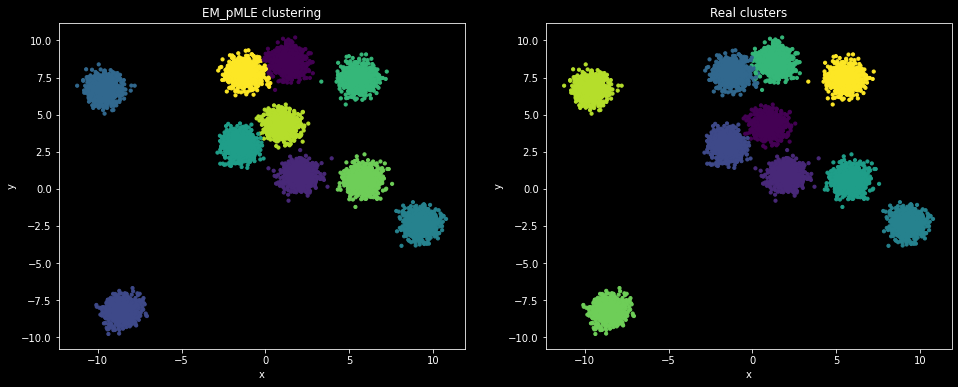

In [19]:
"""Plotting data """
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(X[:,0], X[:,1], s = 10  ,c = labels , cmap='viridis')
ax2.scatter(X[:,0], X[:,1], s = 10 , c = y_true, cmap='viridis')
ax1.set_title('EM_pMLE clustering')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax2.set_title('Real clusters')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
plt.show()

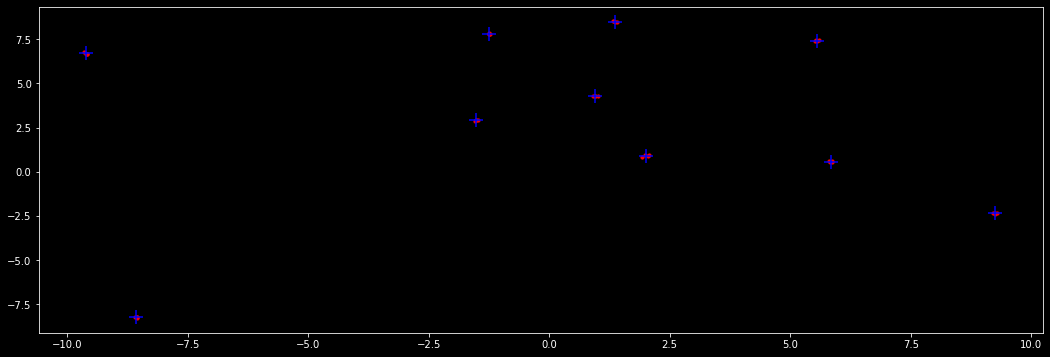

In [20]:
"""Means """
fig = plt.figure(figsize=(18,6))
plt.scatter(DLFGM.AVG_means[:,0],DLFGM.AVG_means[:,1], s=10, c="red")
plt.scatter(DLFGM.Means[:,0], DLFGM.Means[:,1] , s =200 , c ="blue" , marker='+')
plt.show()

In [ ]:
""" Loading file library """
import urllib.request
DATA_PATH=""
f = urllib.request.urlretrieve("https://www.math.univ-toulouse.fr/~besse/Wikistat/data/mnist_train.csv",DATA_PATH+"mnist_train.csv")
f = urllib.request.urlretrieve("https://www.math.univ-toulouse.fr/~besse/Wikistat/data/mnist_test.csv",DATA_PATH+"mnist_test.csv")

In [ ]:
trainRDD = sc.textFile(DATA_PATH+"mnist_train.csv"  ).map(lambda l: [float(x) for x in l.split(',')])

trainRDD  = trainRDD.map(lambda x: np.array(x[:-1])+ np.random.normal(0.,0.05, 784 ) ,4 ) 
print("shape trainRDD : ( ",trainRDD.count() ,",", len(trainRDD.first()) , ")")

In [ ]:
%%time
model = Gaussian_mixture_reduction(10).fit(trainRDD , 6 , Parallel_Estimator  = 'GMM')